In [123]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from linearmodels.panel import compare
from statsmodels.stats.outliers_influence import variance_inflation_factor
from linearmodels.panel import PanelOLS, RandomEffects
from scipy.stats import chi2
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

# 1.Data Loading & Preprocessing

In [124]:
# Load data
file_path = '../data/CA2_filled.csv'
data = pd.read_csv(file_path)

# Data preprocessing: dependent and independent variables
# Dependent variable: log(GDP)
# Independent variables: edu_m, edu_f, gra_m, gra_f, gee, er_m, er_f, law, cpi

# Convert variables to appropriate data types (ensure correctness)
data['Country'] = data['Country'].astype('category')
data['Year'] = data['Year'].astype('int')

# Apply log transformation to gdp
data['log_gdp'] = np.log(data['gdp'])

In [125]:
data['gpi'] = data['edu_f'] / data['edu_m']

In [126]:
data.head()

,Country,Year,gdp,gni,edu_m,edu_f,edu,gra_m,gra_f,gee,er_m,er_f,er,law,cpi,log_gdp,gpi
0,China,2004,3061.833173,4420,11.495247,9.856013,10.675630,5.970477,5.209082,2.561830,77.076,65.253,71.230,0,3.824637,8.026769,0.857399
1,China,2005,3390.716159,5020,11.743086,10.133878,10.938482,6.576500,5.935305,2.597241,76.593,64.575,70.652,0,1.776414,8.128796,0.862966
2,China,2006,3800.765796,5830,11.996267,10.442923,11.219595,7.379805,6.775434,2.632324,76.208,63.960,70.154,0,1.649431,8.242958,0.870514
3,China,2007,4319.031398,6840,12.243160,10.718593,11.480876,8.127824,7.717484,2.700735,75.805,63.331,69.640,0,4.816768,8.370786,0.875476
4,China,2008,4711.643449,7630,12.594070,11.025141,11.809605,8.948138,8.781254,3.631788,75.112,62.514,68.886,0,5.925251,8.457792,0.875423


# 2.Before Modeling

## (1)Descriptive statistics

In [127]:
# Descriptive statistics
print("Descriptive Statistics:")
print(data[['gdp', 'edu_m', 'edu_f', 'edu', 'gra_m', 'gra_f', 'gee', 'er_m', 'er_f', 'er', 'law', 'cpi', 'gpi']].describe())

Descriptive Statistics:
                gdp       edu_m       edu_f         edu       gra_m  \
count    220.000000  220.000000  220.000000  220.000000  220.000000   
mean   28189.163922   28.137597   26.365059   27.251328   30.411045   
std    24418.520746   14.491159   13.999286   13.411303   14.293321   
min      892.382103    4.890618    4.443403    4.667010    5.002174   
25%     3720.652241   14.562961   11.889083   13.025368   16.560459   
50%    27749.813115   30.689915   29.336174   31.556111   31.574318   
75%    48413.461503   36.990921   38.090203   37.474835   43.341550   
max    79434.625650   98.777816   57.976088   63.973501   53.613346   

            gra_f         gee        er_m        er_f          er         law  \
count  220.000000  220.000000  220.000000  220.000000  220.000000  220.000000   
mean    42.277963    4.973956   69.755209   52.008773   60.910727    0.390909   
std     21.187207    1.698149    6.245580   10.678652    6.158613    0.489067   
min      5.2

## (2)Correlation analysis


Correlation Matrix:
            gdp     edu_m     edu_f       edu     gra_m     gra_f       gee  \
gdp    1.000000  0.520934  0.857139  0.728798  0.605101  0.857713  0.758551   
edu_m  0.520934  1.000000  0.772625  0.943508  0.607414  0.527537  0.274316   
edu_f  0.857139  0.772625  1.000000  0.939339  0.666159  0.823154  0.623005   
edu    0.728798  0.943508  0.939339  1.000000  0.675843  0.714628  0.473361   
gra_m  0.605101  0.607414  0.666159  0.675843  1.000000  0.796967  0.262682   
gra_f  0.857713  0.527537  0.823154  0.714628  0.796967  1.000000  0.660332   
gee    0.758551  0.274316  0.623005  0.473361  0.262682  0.660332  1.000000   
er_m  -0.761743 -0.333502 -0.726076 -0.559132 -0.624204 -0.850193 -0.713710   
er_f   0.278167  0.319970  0.307443  0.333328 -0.084405  0.068789  0.200868   
er    -0.161470  0.087962 -0.121602 -0.015944 -0.406046 -0.382857 -0.191715   
law    0.700248  0.413708  0.635889  0.555393  0.232805  0.618495  0.671724   
cpi   -0.398780 -0.376727 -0.46

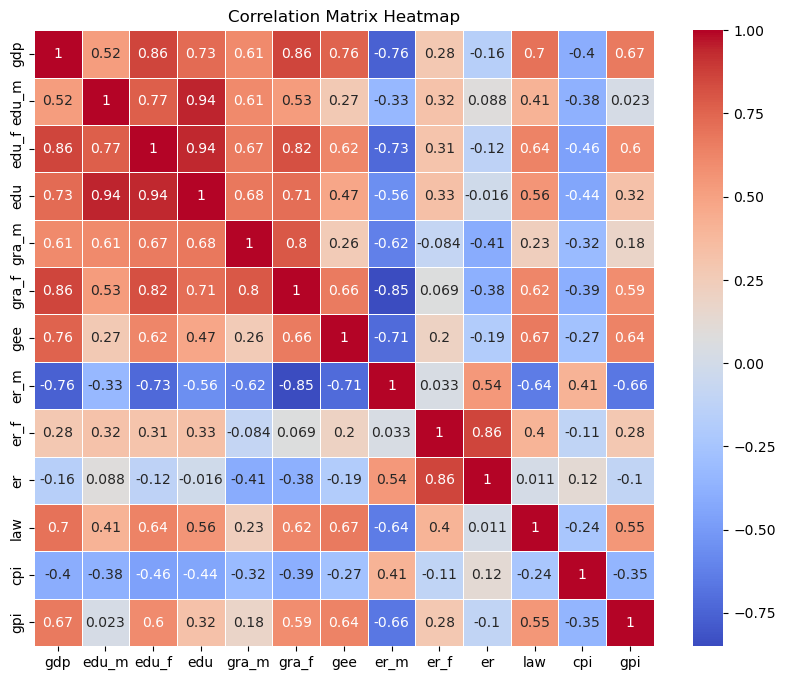

In [128]:
# Correlation analysis
print("\nCorrelation Matrix:")
corr_matrix = data[['gdp', 'edu_m', 'edu_f', 'edu', 'gra_m', 'gra_f', 'gee', 'er_m', 'er_f', 'er', 'law', 'cpi', 'gpi']].corr()
print(corr_matrix)

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

#Box Plot for different variables to analyze distribution, outliers, and spread
plt.figure(figsize=(15, 10))

#List of variables to plot
variables = ['gdp', 'edu_m', 'edu_f', 'gra_m', 'gra_f', 'gee', 'er_m', 'er_f', 'law', 'cpi']

#Loop over variables to create box plots
for i, var in enumerate(variables):
    plt.subplot(3, 4, i+1)  # Arrange subplots in a 3x4 grid
    sns.boxplot(data=data, y=var)
    plt.title(f'Box Plot of {var}')

plt.tight_layout()
plt.show()

## (3)Feature Selection

In [129]:
# Multicollinearity check using Variance Inflation Factor (VIF) before removing variables
print("\nVariance Inflation Factor (VIF) before removing variables:")
X = data[['edu_m', 'edu_f', 'gra_m', 'gra_f', 'gee', 'er_m', 'er_f', 'law', 'cpi']].copy()
X.loc[:, 'Intercept'] = 1  # Add intercept for VIF calculation
vif_data_before = pd.DataFrame()
vif_data_before['Variable'] = X.columns
vif_data_before['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data_before)

# Remove highly collinear variables gra_m and gra_f
data = data.drop(columns=['gra_m', 'gra_f'])

# Multicollinearity check using Variance Inflation Factor (VIF) after removing variables
print("\nVariance Inflation Factor (VIF) after removing variables:")
X = data[['edu_m', 'edu_f', 'gee', 'er_m', 'er_f', 'law', 'cpi']].copy()
X.loc[:, 'Intercept'] = 1  # Add intercept for VIF calculation
vif_data_after = pd.DataFrame()
vif_data_after['Variable'] = X.columns
vif_data_after['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data_after)


Variance Inflation Factor (VIF) before removing variables:
    Variable          VIF
0      edu_m     5.369602
1      edu_f     9.181328
2      gra_m     8.013070
3      gra_f    11.918430
4        gee     3.334180
5       er_m     7.402679
6       er_f     1.770175
7        law     3.999863
8        cpi     1.403122
9  Intercept  1112.538442

Variance Inflation Factor (VIF) after removing variables:
    Variable         VIF
0      edu_m    3.704832
1      edu_f    7.766050
2        gee    2.621380
3       er_m    4.947926
4       er_f    1.737251
5        law    2.766147
6        cpi    1.347268
7  Intercept  648.737755


## (4)Model Selection--Hausman test

In [130]:
# Hausman test for fixed vs. random effects
# Using linearmodels library for panel data regression
from linearmodels.panel import compare

# Fixed effects model
fixed_effects = PanelOLS.from_formula('log_gdp ~ edu_m + edu_f + gee + er_m + er_f + law + cpi + EntityEffects', data=data.set_index(['Country', 'Year'])).fit()

# Random effects model
random_effects = RandomEffects.from_formula('log_gdp ~ edu_m + edu_f + gee + er_m + er_f + law + cpi', data=data.set_index(['Country', 'Year'])).fit()

# Standard Hausman test
print("\nHausman Test:")
fe_params = fixed_effects.params
re_params = random_effects.params
common_params = fe_params.index.intersection(re_params.index)

b_diff = fe_params[common_params] - re_params[common_params]
V_fe = fixed_effects.cov.loc[common_params, common_params]
V_re = random_effects.cov.loc[common_params, common_params]
V_diff = V_fe - V_re

hausman_stat = b_diff.T @ np.linalg.inv(V_diff) @ b_diff
p_value = 1 - chi2.cdf(hausman_stat, len(common_params))

print(f"Hausman Statistic: {hausman_stat}")
print(f"P-value: {p_value}")


## Print regression results with p-values instead of standard errors
#print("\nFixed Effects Model Results:")
#print(fixed_effects.summary.tables[1].as_text().replace('Std. Err.', 'P-value'))

#print("\nRandom Effects Model Results:")
#print(random_effects.summary.tables[1].as_text().replace('Std. Err.', 'P-value'))


Hausman Test:
Hausman Statistic: 433.2209073397926
P-value: 0.0


d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:590: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mu = self._frame.groupby(level=level).transform("mean")
d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:590: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mu = self._frame.groupby(level=level).transform("mean")
d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:680: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior o

## (5) Visualisation of GDP per capita

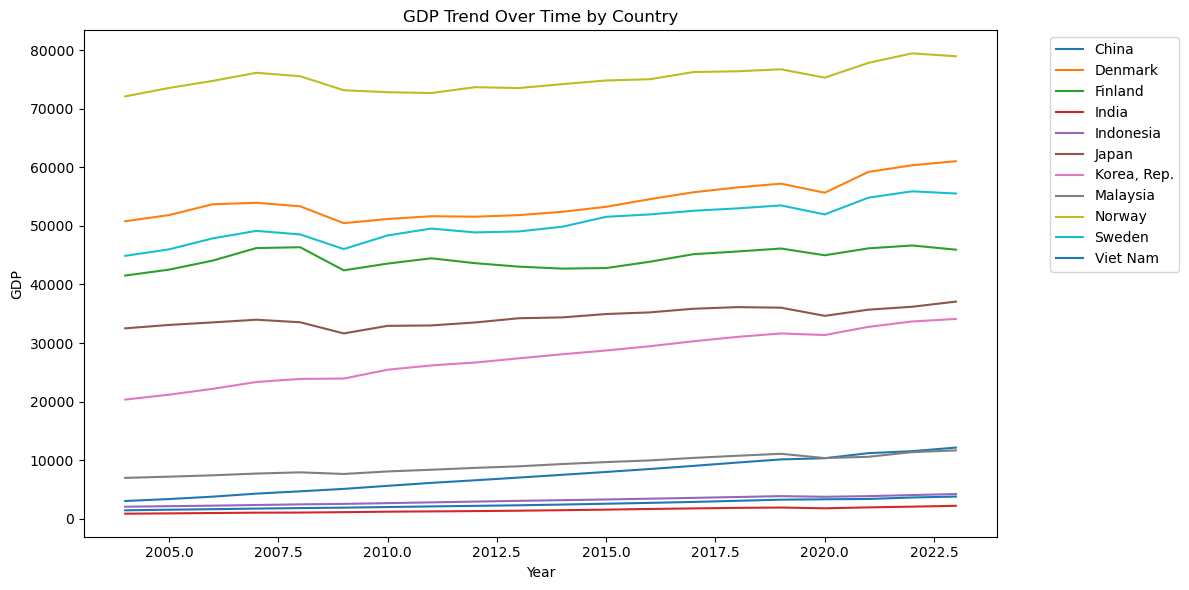

In [131]:
# Plot GDP trend over time for each country using seaborn
plt.figure(figsize=(12, 6))
for country in data['Country'].unique():
    country_data = data[data['Country'] == country]
    plt.plot(country_data['Year'], country_data['gdp'], label=country)

plt.xlabel('Year')
plt.ylabel('GDP')
plt.title('GDP Trend Over Time by Country')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 3.Fixed Effect Model(no interactions)

#### "Since both the general model and the sub-models exhibit heteroskedasticity and autocorrelation, robust standard errors will be used to estimate the regression models."

## (1)General model

In [132]:
# Fixed effects regression
fe_model = PanelOLS.from_formula('log_gdp ~ gpi + gee + er_m + er_f + law + cpi + EntityEffects', 
                                 data=data.set_index(['Country', 'Year'])).fit(cov_type='robust')

# Output the regression result
print("\nFixed Effects Regression Results:")
print(fe_model.summary)


Fixed Effects Regression Results:
                          PanelOLS Estimation Summary                           
Dep. Variable:                log_gdp   R-squared:                        0.3040
Estimator:                   PanelOLS   R-squared (Between):             -0.5362
No. Observations:                 220   R-squared (Within):               0.3040
Date:                Fri, Oct 25 2024   R-squared (Overall):             -0.5358
Time:                        00:30:23   Log-likelihood                    82.261
Cov. Estimator:                Robust                                           
                                        F-statistic:                      14.776
Entities:                          11   P-value                           0.0000
Avg Obs:                       20.000   Distribution:                   F(6,203)
Min Obs:                       20.000                                           
Max Obs:                       20.000   F-statistic (robust):             

d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:590: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mu = self._frame.groupby(level=level).transform("mean")
d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:590: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mu = self._frame.groupby(level=level).transform("mean")
d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:680: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior o

In [133]:
## Random effects regression
#re_model = RandomEffects.from_formula('log_gdp ~ gpi + gee + er_m + er_f + law + cpi', data=data.set_index(['Country', 'Year'])).fit(cov_type='robust')

## Output the regression result
#print("\nRandom Effects Regression Results:")
#print(re_model.summary)

## (2)Sub-models

### Male-specific model

In [134]:
# Fixed effects regression for male data only with robust standard errors
fe_model_male = PanelOLS.from_formula('log_gdp ~ edu_m + gee + er_m + law + cpi + EntityEffects', data=data.set_index(['Country', 'Year'])).fit(cov_type='robust')

# Output the regression result for male data
print("\nFixed Effects Regression Results (Male) with Robust Standard Errors:")
print(fe_model_male.summary)


Fixed Effects Regression Results (Male) with Robust Standard Errors:
                          PanelOLS Estimation Summary                           
Dep. Variable:                log_gdp   R-squared:                        0.3619
Estimator:                   PanelOLS   R-squared (Between):             -0.7303
No. Observations:                 220   R-squared (Within):               0.3619
Date:                Fri, Oct 25 2024   R-squared (Overall):             -0.7298
Time:                        00:30:24   Log-likelihood                    91.811
Cov. Estimator:                Robust                                           
                                        F-statistic:                      23.135
Entities:                          11   P-value                           0.0000
Avg Obs:                       20.000   Distribution:                   F(5,204)
Min Obs:                       20.000                                           
Max Obs:                       20.000  

d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:590: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mu = self._frame.groupby(level=level).transform("mean")
d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:590: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mu = self._frame.groupby(level=level).transform("mean")
d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:680: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior o

### Female-specific model

In [135]:
# Fixed effects regression for female data only with robust standard errors
fe_model_female = PanelOLS.from_formula('log_gdp ~ edu_f + gee + er_f + law + cpi + EntityEffects', data=data.set_index(['Country', 'Year'])).fit(cov_type='robust')

# Output the regression result for female data
print("\nFixed Effects Regression Results (Female) with Robust Standard Errors:")
print(fe_model_female.summary)


Fixed Effects Regression Results (Female) with Robust Standard Errors:
                          PanelOLS Estimation Summary                           
Dep. Variable:                log_gdp   R-squared:                        0.3977
Estimator:                   PanelOLS   R-squared (Between):             -0.0254
No. Observations:                 220   R-squared (Within):               0.3977
Date:                Fri, Oct 25 2024   R-squared (Overall):             -0.0252
Time:                        00:30:24   Log-likelihood                    98.176
Cov. Estimator:                Robust                                           
                                        F-statistic:                      26.943
Entities:                          11   P-value                           0.0000
Avg Obs:                       20.000   Distribution:                   F(5,204)
Min Obs:                       20.000                                           
Max Obs:                       20.000

d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:590: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mu = self._frame.groupby(level=level).transform("mean")
d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:590: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mu = self._frame.groupby(level=level).transform("mean")
d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:680: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior o

# 4.Fixed Effect Model(with interactions)---重点讲这个有交互项的模型

In [136]:
# Create interaction terms
data['law_er_m'] = data['law'] * data['er_m']
data['law_er_f'] = data['law'] * data['er_f']

## (1)General model

In [137]:
# Fixed effects regression with interaction terms
fe_model1 = PanelOLS.from_formula('log_gdp ~ edu_m + edu_f + gee + er_m + er_f + law + cpi + law_er_m + law_er_f + EntityEffects',
                                 data=data.set_index(['Country', 'Year'])).fit(cov_type='robust')

# Output the regression result
print("\nFixed Effects Regression Results with Interaction Terms:")
print(fe_model1.summary)

d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:590: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mu = self._frame.groupby(level=level).transform("mean")
d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:590: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mu = self._frame.groupby(level=level).transform("mean")



Fixed Effects Regression Results with Interaction Terms:
                          PanelOLS Estimation Summary                           
Dep. Variable:                log_gdp   R-squared:                        0.5959
Estimator:                   PanelOLS   R-squared (Between):             -1.1861
No. Observations:                 220   R-squared (Within):               0.5959
Date:                Fri, Oct 25 2024   R-squared (Overall):             -1.1853
Time:                        00:30:24   Log-likelihood                    142.06
Cov. Estimator:                Robust                                           
                                        F-statistic:                      32.765
Entities:                          11   P-value                           0.0000
Avg Obs:                       20.000   Distribution:                   F(9,200)
Min Obs:                       20.000                                           
Max Obs:                       20.000   F-statistic

d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:680: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mu = self._frame.groupby(level=level).mean()
d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:680: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mu = self._frame.groupby(level=level).mean()
d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:640: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the futur

## (2)Sub-models

### Male-specific model

In [138]:
# Fixed effects regression for male data only with interaction term and robust standard errors
fe_model_male1 = PanelOLS.from_formula('log_gdp ~ edu_m + gee + er_m + law + cpi + law_er_m + EntityEffects', data=data.set_index(['Country', 'Year'])).fit(cov_type='robust')

# Output the regression result for male data
print("\nFixed Effects Regression Results (Male) with Interaction Term and Robust Standard Errors:")
print(fe_model_male1.summary)


Fixed Effects Regression Results (Male) with Interaction Term and Robust Standard Errors:
                          PanelOLS Estimation Summary                           
Dep. Variable:                log_gdp   R-squared:                        0.4221
Estimator:                   PanelOLS   R-squared (Between):             -1.2424
No. Observations:                 220   R-squared (Within):               0.4221
Date:                Fri, Oct 25 2024   R-squared (Overall):             -1.2417
Time:                        00:30:24   Log-likelihood                    102.72
Cov. Estimator:                Robust                                           
                                        F-statistic:                      24.712
Entities:                          11   P-value                           0.0000
Avg Obs:                       20.000   Distribution:                   F(6,203)
Min Obs:                       20.000                                           
Max Obs:          

d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:590: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mu = self._frame.groupby(level=level).transform("mean")
d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:590: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mu = self._frame.groupby(level=level).transform("mean")
d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:680: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior o

### Female-specific model

In [139]:
# Fixed effects regression for female data only with interaction term and robust standard errors
fe_model_female1 = PanelOLS.from_formula('log_gdp ~ edu_f + gee + er_f + law + cpi + law_er_f + EntityEffects', data=data.set_index(['Country', 'Year'])).fit(cov_type='robust')

# Output the regression result for female data
print("\nFixed Effects Regression Results (Female) with Interaction Term and Robust Standard Errors:")
print(fe_model_female1.summary)


Fixed Effects Regression Results (Female) with Interaction Term and Robust Standard Errors:
                          PanelOLS Estimation Summary                           
Dep. Variable:                log_gdp   R-squared:                        0.4097
Estimator:                   PanelOLS   R-squared (Between):             -0.0584
No. Observations:                 220   R-squared (Within):               0.4097
Date:                Fri, Oct 25 2024   R-squared (Overall):             -0.0582
Time:                        00:30:24   Log-likelihood                    100.39
Cov. Estimator:                Robust                                           
                                        F-statistic:                      23.483
Entities:                          11   P-value                           0.0000
Avg Obs:                       20.000   Distribution:                   F(6,203)
Min Obs:                       20.000                                           
Max Obs:        

d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:590: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mu = self._frame.groupby(level=level).transform("mean")
d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:590: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mu = self._frame.groupby(level=level).transform("mean")
d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:680: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior o

# 5.After Modeling(tests)

## (1)Breusch-Pagan Heteroskedasticity Test & Durbin-Watson Test-------不用汇报这一部分，直接在模型部分说一句‘使用稳健标准误进行回归估计防止异方差和自相关’即可

In [140]:
# Extract the independent variables from the model and add a constant term
exog = data[['edu_m', 'edu_f', 'gee', 'er_m', 'er_f', 'law', 'cpi', 'law_er_m', 'law_er_f']].values
exog = sm.add_constant(exog)  # Add a constant term

# Extract residuals
residuals = fe_model1.resids

# 1. Breusch-Pagan Heteroskedasticity Test
bp_test = het_breuschpagan(residuals, exog)

# Extract test results
bp_test_stat = bp_test[0]  # LM statistic
bp_p_value = bp_test[1]  # P-value for the LM statistic

print("Breusch-Pagan Test Statistic:", bp_test_stat)
print("P-value for Breusch-Pagan Test:", bp_p_value)

# 2. Durbin-Watson Test
dw_stat = durbin_watson(residuals)

print("Durbin-Watson Statistic:", dw_stat)

Breusch-Pagan Test Statistic: 44.8679335067058
P-value for Breusch-Pagan Test: 9.760324593439203e-07
Durbin-Watson Statistic: 0.5721574252680062


In [141]:
# Extract the independent variables from the model and add a constant term
exog = data[['edu_m', 'gee', 'er_m', 'law', 'cpi']].values
exog = sm.add_constant(exog)  # Add a constant term

# Extract residuals
residuals = fe_model_male.resids

# 1. Breusch-Pagan Heteroskedasticity Test
bp_test = het_breuschpagan(residuals, exog)

# Extract test results
bp_test_stat = bp_test[0]  # LM statistic
bp_p_value = bp_test[1]  # P-value for the LM statistic

print("Breusch-Pagan Test Statistic:", bp_test_stat)
print("P-value for Breusch-Pagan Test:", bp_p_value)

# 2. Durbin-Watson Test
dw_stat = durbin_watson(residuals)

print("Durbin-Watson Statistic:", dw_stat)

Breusch-Pagan Test Statistic: 37.218442305275204
P-value for Breusch-Pagan Test: 5.414881443936361e-07
Durbin-Watson Statistic: 0.6024609108408521


In [142]:
# Extract the independent variables from the model and add a constant term
exog = data[['edu_f', 'gee', 'er_f', 'law', 'cpi']].values
exog = sm.add_constant(exog)  # Add a constant term

# Extract residuals
residuals = fe_model_female.resids

# 1. Breusch-Pagan Heteroskedasticity Test
bp_test = het_breuschpagan(residuals, exog)

# Extract test results
bp_test_stat = bp_test[0]  # LM statistic
bp_p_value = bp_test[1]  # P-value for the LM statistic

print("Breusch-Pagan Test Statistic:", bp_test_stat)
print("P-value for Breusch-Pagan Test:", bp_p_value)

# 2. Durbin-Watson Test
dw_stat = durbin_watson(residuals)

print("Durbin-Watson Statistic:", dw_stat)

Breusch-Pagan Test Statistic: 31.964915093755216
P-value for Breusch-Pagan Test: 6.037063081787875e-06
Durbin-Watson Statistic: 0.5286513064705765


## (2)Robustness check-----直接汇报那张稳健性检验的三线表就行

In [143]:
# Fixed effects regression with interaction terms
fe_model = PanelOLS.from_formula('log_gdp ~ edu_m + edu_f + gee + er_m + er_f + law + cpi + law_er_m + law_er_f + EntityEffects', 
                                 data=data.set_index(['Country', 'Year'])).fit(cov_type='kernel')
# Output the regression result
print("\nFixed Effects Regression Results with Interaction Terms and kernel Standard Errors:")
print(fe_model.summary)

# Fixed effects regression for male data only with interaction term and kernel standard errors
fe_model_male = PanelOLS.from_formula('log_gdp ~ edu_m + gee + er_m + law + cpi + law_er_m + EntityEffects', data=data.set_index(['Country', 'Year'])).fit(cov_type='kernel')
# Output the regression result for male data
print("\nFixed Effects Regression Results (Male) with Interaction Term and kernel Standard Errors:")
print(fe_model_male.summary)

# Fixed effects regression for female data only with interaction term and kernel standard errors
fe_model_female = PanelOLS.from_formula('log_gdp ~ edu_f + gee + er_f + law + cpi + law_er_f + EntityEffects', data=data.set_index(['Country', 'Year'])).fit(cov_type='kernel')
# Output the regression result for female data
print("\nFixed Effects Regression Results (Female) with Interaction Term and kernel Standard Errors:")
print(fe_model_female.summary)

d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:590: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mu = self._frame.groupby(level=level).transform("mean")
d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:590: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mu = self._frame.groupby(level=level).transform("mean")
d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:680: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior o


Fixed Effects Regression Results with Interaction Terms and kernel Standard Errors:
                          PanelOLS Estimation Summary                           
Dep. Variable:                log_gdp   R-squared:                        0.5959
Estimator:                   PanelOLS   R-squared (Between):             -1.1861
No. Observations:                 220   R-squared (Within):               0.5959
Date:                Fri, Oct 25 2024   R-squared (Overall):             -1.1853
Time:                        00:30:24   Log-likelihood                    142.06
Cov. Estimator:        Driscoll-Kraay                                           
                                        F-statistic:                      32.765
Entities:                          11   P-value                           0.0000
Avg Obs:                       20.000   Distribution:                   F(9,200)
Min Obs:                       20.000                                           
Max Obs:                

d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:590: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mu = self._frame.groupby(level=level).transform("mean")
d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:590: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mu = self._frame.groupby(level=level).transform("mean")
d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:680: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior o

In [144]:
# Fit models and collect results
model_summaries = []

## kernal
# Fixed effects regression with interaction terms
fe_model_kernel = PanelOLS.from_formula('log_gdp ~ edu_m + edu_f + gee + er_m + er_f + law + cpi + law_er_m + law_er_f + EntityEffects', data=data.set_index(['Country', 'Year'])).fit(cov_type='kernel')
model_summaries.append(fe_model_kernel)

# Fixed effects regression for male data only with interaction term and kernel standard errors
fe_model_male_kernel = PanelOLS.from_formula('log_gdp ~ edu_m + gee + er_m + law + cpi + law_er_m + EntityEffects', data=data.set_index(['Country', 'Year'])).fit(cov_type='kernel')
model_summaries.append(fe_model_male_kernel)

# Fixed effects regression for female data only with interaction term and kernel standard errors
fe_model_female_kernel = PanelOLS.from_formula('log_gdp ~ edu_f + gee + er_f + law + cpi + law_er_f + EntityEffects', data=data.set_index(['Country', 'Year'])).fit(cov_type='kernel')
model_summaries.append(fe_model_female_kernel)

## robust
# Fixed effects regression with interaction terms
fe_model_robust = PanelOLS.from_formula('log_gdp ~ edu_m + edu_f + gee + er_m + er_f + law + cpi + law_er_m + law_er_f + EntityEffects', data=data.set_index(['Country', 'Year'])).fit(cov_type='robust')
model_summaries.append(fe_model_robust)

# Fixed effects regression for male data only with interaction term and robust standard errors
fe_model_male_robust = PanelOLS.from_formula('log_gdp ~ edu_m + gee + er_m + law + cpi + law_er_m + EntityEffects', data=data.set_index(['Country', 'Year'])).fit(cov_type='robust')
model_summaries.append(fe_model_male_robust)

# Fixed effects regression for female data only with interaction term and robust standard errors
fe_model_female_robust = PanelOLS.from_formula('log_gdp ~ edu_f + gee + er_f + law + cpi + law_er_f + EntityEffects', data=data.set_index(['Country', 'Year'])).fit(cov_type='robust')
model_summaries.append(fe_model_female_robust)

# Create a table to display results
all_params = set()
for model in model_summaries:
    all_params.update(model.params.index)
all_params = list(all_params)

results_table = pd.DataFrame(index=all_params, columns=['general model (robust)', 'general model (kernel)', 'male model (robust)', 'male model (kernel)', 'female model (robust)', 'female model (kernel)'])

for i, model in enumerate(model_summaries):
    # Extract coefficients and p-values
    coefs = model.params
    pvals = model.pvalues
    for param in all_params:
        if param in coefs.index:
            results_table.iloc[all_params.index(param), i] = f"{coefs[param]:.4f} ({pvals[param]:.4f})"

# Display the table
print("\nRegression Coefficients Table:")
print(results_table)

d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:590: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mu = self._frame.groupby(level=level).transform("mean")
d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:590: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mu = self._frame.groupby(level=level).transform("mean")
d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:680: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior o


Regression Coefficients Table:
         general model (robust) general model (kernel) male model (robust)  \
edu_m          -0.0006 (0.7128)        0.0090 (0.0192)                 NaN   
law_er_m        0.1358 (0.0000)        0.0393 (0.0026)                 NaN   
gee             0.0098 (0.6515)       -0.0221 (0.2996)     0.0007 (0.9762)   
law_er_f       -0.0845 (0.0000)                    NaN     0.0142 (0.0576)   
cpi            -0.0023 (0.5914)       -0.0061 (0.2126)    -0.0195 (0.0004)   
er_m           -0.0915 (0.0000)       -0.0696 (0.0000)                 NaN   
law            -4.4019 (0.0000)       -2.8771 (0.0009)    -0.9119 (0.0363)   
er_f            0.0276 (0.0021)                    NaN    -0.0152 (0.0079)   
edu_f           0.0153 (0.0000)                    NaN     0.0219 (0.0000)   

         male model (kernel) female model (robust) female model (kernel)  
edu_m       -0.0006 (0.6490)       0.0090 (0.0006)                   NaN  
law_er_m     0.1358 (0.0000)       0.

d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:590: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mu = self._frame.groupby(level=level).transform("mean")
d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:590: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mu = self._frame.groupby(level=level).transform("mean")
d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:680: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior o